In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import sys

## On va résoudre l'équation de Vlasov-Poisson 1D x 1D :

### $$
    \begin{cases}
        \ \partial_{t}f(t,x,v) + v\partial_{x}f(t,x,v)-E(t,x)\partial_{v}f(t,x,v) = 0 \\   
        \ \partial_{x}E(t,x) =\int_{\mathbb{R}}f(t,x,v)dv-1 \ , avec  \ x \in [0,\frac{2\pi}{k}] \ ,\  v\in [-8,8] 
    \end{cases}
   $$




Commençons par définir le maillage et l'initialisation






In [2]:
Nx = 64
Nv = 64
k = 0.5
eps = 0.01
dt = 0.2
v0 = 2.4
xmin = 0.0
xmax =4.0*np.pi
vmin = -8.0
vmax = 8.0
dx=(xmax-xmin)/Nx
dv=(vmax-vmin)/Nv
meshx=xmin+dx*np.arange(Nx)
meshv=vmin+dv*np.arange(Nv)
x,v = np.meshgrid(meshx,meshv)

### Fonction initiale:

### $$f(t=0,x,v)= \frac{1}{\sqrt{2\pi}}e^{\frac{-v^{2}}{2}}(1+\varepsilon  cos(kx))$$

In [3]:
def fun_landau(x,v,choix_test):
    if(choix_test==1):
        return (1.0+eps*np.cos(k*x))*(np.exp(-0.5*((v-v0)**2))+np.exp(-0.5*(((v+v0)**2))))/np.sqrt(2*np.pi)
    elif(choix_test==2):
        return (1.0/np.sqrt(2.0*np.pi))*np.exp(-v**2/2.0)*(1 + eps*np.cos(k*x))

Initialisation

In [20]:
choix_test=2
f0 = fun_landau(x,v,choix_test)

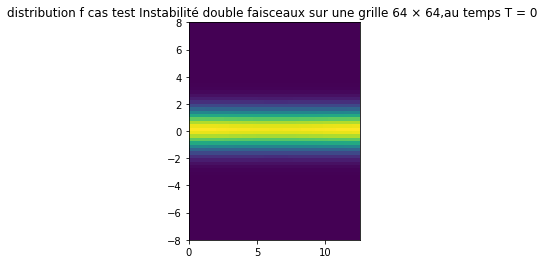

In [21]:
pl.title('distribution f cas test Instabilité double faisceaux sur une grille 64 × 64,au temps T = 0 ')
im = pl.imshow(f0,extent=(xmin,xmax,vmin,vmax),origin='lower')

# Présentation de l’algorithme

L’objectif est de construire des approximations numériques pour résoudre l’équation Vlasov-Poisson 1D x 1D

### Méthodes de splitting:
On se ramène à un problème 1D.
<br />
On cosidère dans un premier temps l’advection en X:
<br />
En résolvant sur $\Delta  t $
### $$\partial_{t}f+v\partial_{x}f=0 (1)$$
<br />



Par une méthode semi-Lagrangienne. on deux étapes pour calculer la fonction de distribution $f_{n+1}$ au temps $t_{n+1}$ à partir de la fonction de distribution $f_{n}$  au temps$t_{n}$  :
<br />
1)Pour chaque point $x_{i}$ du maillage de l'espace des phases, calculer $X(t_{n};x_{i}, t_{n+1})$
<br />
la valeur de la caractéristique en $t_{n}$ qui vaut $x_{i}$ en $t_{n+1}$.
<br />
2)Comme la fonction de distribution solution de l'équation vérifie
$$f_{n+1}(x_{i}) = f_{n}(X(t_{n}; x_{i}, t_{n+1}))$$
on obtient la valeur $ f_{n+1}(x_{i}) $ cherchée, en calculant $f_{n}(X(t_{n}; x_{i}, t_{n+1}))$ par interpolation
<br />
car $X(t_{n}; x_{i}, t_{n+1})$ n'est en général pas un point du maillage.
<br />
L'équation (1) à pour solution explicite sur un pas de temps $\Delta t$ :

### $$f(x,v,t+\Delta t)=f(x-v\Delta  t,v,t)$$
On obtient ainsi, en plus de la valeur de f aux points du maillage la valeurs de ses
dérivées dont on a besoin pour une interpolation.
<br />
On pose :  $ x_{i}-v\Delta  t = x_{j}+\alpha \Delta x  $  avec  $0 \leq \alpha<1$
<br />
Donc $ i-v\frac{\Delta  t}{\Delta  x} = j+\alpha$ 
### Et 
### $$f_{i}^{n+1}=(1-\alpha)f_{j}^{n}+\alpha f_{j+1}^{n} $$


###### Calcul de l'interpolation

In [22]:
def advect1d(p,f_new,f_old,a,L,dt):
    npts = np.size(f_old)
    n = npts
    #-a*n/L = i0+alpha i0 dans Z et 0<=alpha<1
    x = -a*dt/L
    i0 = np.floor(x)
    alpha = x-i0
    for i in range(n):
        jn3 = int(i0+i-3)%n
        jn2 = int(i0+i-2)%n
        jn1 = int(i0+i-1)%n
        j = int(i0+i)%n
        jp1 = int(i0+i+1)%n
        jp2 = int(i0+i+2)%n
        jp3 = int(i0+i+3)%n
        if (p==1):
            f_new[i]=alpha*f_old[jp1] +(1-alpha)*f_old[j] # une interpolation de degré 1
            
        elif (p==3):
            L_n1=-alpha*(alpha-1)*(alpha-2)/6
            L_0=(alpha+1)*(alpha-1)*(alpha-2)/2
            L_1=-alpha*(alpha+1)*(alpha-2)/2
            L_2=alpha*(alpha-1)*(alpha+1)/6
            f_new[i]=L_n1*f_old[jn1] +L_0*f_old[j]+L_1*f_old[jp1]+L_2*f_old[jp2] # une interpolation de degré 3
            
        elif (p==6):
            # une interpolation de degré 6
            L_n3=alpha*(alpha+2)*(alpha+1)*(alpha-1)*(alpha-2)*(alpha-3)/720
            L_n2=-alpha*(alpha+3)*(alpha+1)*(alpha-1)*(alpha-2)*(alpha-3)/120
            L_n1=alpha*(alpha+3)*(alpha+2)*(alpha-1)*(alpha-2)*(alpha-3)/48
            L_0=-(alpha+1)*(alpha+3)*(alpha+2)*(alpha-1)*(alpha-2)*(alpha-3)/36
            L_1=alpha*(alpha+3)*(alpha+2)*(alpha+1)*(alpha-2)*(alpha-3)/48
            L_2=-alpha*(alpha+3)*(alpha+1)*(alpha-1)*(alpha+2)*(alpha-3)/120
            L_3=alpha*(alpha+2)*(alpha+1)*(alpha-1)*(alpha-2)*(alpha+3)/720
            f_new[i]=L_n3*f_old[jn3]+L_n2*f_old[jn2]+L_n1*f_old[jn1]+L_0*f_old[j]+L_1*f_old[jp1]+L_2*f_old[jp2]+L_3*f_old[jp3] # une interpolation de degré 6
      
    return f_new  

###### L'advection en x

In [23]:
def advect_x(f,a,dt,dx,p):
    npts_x = np.size(f,1)
    npts_v = np.size(f,0)
    f1d_old = np.zeros(npts_x)
    f1d_new = np.zeros(npts_x)
    if(np.size(a)!=npts_v):
        print("bad size for a")
        sys.exit()
  
    for j in range(npts_v):
        f1d_old = f[j,:]
     
        advect1d(p,f1d_new,f1d_old,a[j],dx,dt)
        f[j,:]=f1d_new
    return f    

L'advection en v pour un champ électrique E(x) :

### $$\partial_{t}f+E\partial_{v}f=0 $$
On utilise la transformée de fourier discrète pour approcher $\partial_{x}E$
<br />
Donc $$\partial_{x}E(t,x) =\int_{\mathbb{R}}f(t,x,v)dv-1 $$ on pose $\rho(x,t)= \int_{\mathbb{R}}f(t,x,v)dv-1 $

transformée de fourier discrète direct (TFD):

$$\hat{\rho}_{k}=\sum_{n=-\frac{N}{2}}^{\frac{N}{2}+1} \rho_{n}e^{-2i\pi n\frac{k}{N}} $$

transformée de fourier discrète inverse (TFDD):

$$\rho_{n}=\sum_{k=-\frac{N}{2}}^{\frac{N}{2}+1} \hat{\rho}_{k}e^{2i\pi n\frac{k}{N}} $$
transformation de Fourier et dérivation:

$$\mathcal{F}(\partial_{x}E)=\frac{2i\pi k}{L}\hat{E}_{k} $$


avec :
<br />
N : nombre de points temporels 
<br />
n  : variable temporelle $n = 0, ..., N−1$
<br />
L : Nombre de points fréquentiels
<br />
k : variable fréquentielle $k = 0, ..., L−1$
<br />
on considérera L=N


###### Calcul de champ électrique

In [24]:
def champ_E(f,dv,xmax,xmin):
    nx =np.size(f,1)
    rho = 1.0 - (dv)*np.sum(f,axis=0)
    modes = 2*np.pi*np.arange(nx/2+1)/(xmax-xmin)
    rhok = np.fft.rfft(rho)
    modes[0] = 1.  # avoid division by 0
    Z = (np.fft.irfft((-1j*rhok/modes)))
    return Z


###### L'advection en v

In [25]:
def advect_v(f,E,dv,dt,p):
    npts_x = np.size(f,1)
    npts_v = np.size(f,0)
    f1d_old = np.zeros(npts_v)
    f1d_new = np.zeros(npts_v)
    if(np.size(E)!=npts_x):
        print("bad size for a")
        sys.exit()  
    for i in range(npts_x):
        f1d_old = f[:,i]
        advect1d(p,f1d_new,f1d_old,-E[i],dv,dt)
        f[:,i] = f1d_new
    return f

###### La norme L2

In [26]:
def normeL2(h,U):
    return np.sqrt(h*np.sum(U**2))

###### Solution analytique du mode dominant du champ électrique

$$E(x,t)\approx 4\epsilon re^{w_{i}t}sin(kx)cos(w_{r}t-\varphi)$$
On note qu'on a toujours pour une racine de la form $w_{r}+iw_{i}$ associée au résidus $re^{-i\varphi}$




In [27]:
def theorique_champ(A,t,k,meshx):
    if(k==0.5):
        return 4*A*0.3677*np.exp(-0.1533*t)*np.sin(k*meshx)*np.cos(1.4156*t-0.536245)
    if (k==0.3):
        return 4*A*0.63678*np.exp(-0.0126*t)*np.sin(k*meshx)*np.cos(1.1598*t-0.114267)

###### Fonction principale

In [ ]:
p=3
f = f0.copy()
E=champ_E(f,dv,xmax,xmin)
pl.title('distribution f cas test L’amortissement Landau sur une grille 64 × 64,au temps T = 100')
im = pl.imshow(f0,extent=(xmin,xmax,vmin,vmax),origin='lower')
nr =500
time = dt*np.arange(nr+1)
l2_f =np.zeros(nr+1)
l3_f =np.zeros(nr+1)
ET=theorique_champ(eps,time[0],k,meshx)
l4_f =np.zeros(nr+1)
l3_f[0] =np.sqrt(1/(xmax))*normeL2(dx,E)
l4_f[0] =np.sqrt(1/(xmax))*normeL2(dx,ET)
l2_f[0] = np.sum(f**2)
for n in range(nr):

    f=advect_v(f,E,dv,0.5*dt,p)
   
    f=advect_x(f,meshv,dt,dx,p)
 
    E=champ_E(f,dv,xmax,xmin)
   
    f=advect_v(f,E,dv,0.5*dt,p)
    
    ET=theorique_champ(eps,time[n+1],k,meshx)
    
    l3_f[n+1] =np.sqrt(1/(xmax))*normeL2(dx,E)
    
    l2_f[n+1]= np.sum(f**2)
    
    l4_f[n+1] =np.sqrt(1/(xmax))*normeL2(dx,ET)
    
im.set_data(f)
im.set_array(f)


### Validation des codes Vlasov-Poisson 1Dx1D

Pour les codes semi-Lagrangiens,il faudra vérifier l’interpolation,le solveur de Poisson et ́eventuellement la résolution numérique des caractéristique.
<br />
Une fois toutes les briques de base validées, on passe à la validation du code globale  en uutilisant les solution connues de vlasov-poisson. 
<br />
Nous considérons deux cas de tests classique 
<br />
- l'amortissement landau 
<br />
- l'instabilité double faisceau    

### l'amortissement landau 

La condition initiale de l’amortissement Landau correspond à :

$$f(t=0,x,v)= \frac{1}{\sqrt{2\pi}}e^{\frac{-v^{2}}{2}}(1+\varepsilon  cos(kx)) , L= 4\pi $$
Dans les simulations numérique on prenons  $\epsilon$ comme une petit perturbation d'un équilibre Maxwellien.
<br />
Cet équilibre est stable et la fonction de distribution revient à l'étas d'équilibre apres la perturbation. 



In [ ]:
pl.title('L’amortissement Landau pour, k ='+str(k))
pl.plot(time,np.log(l3_f),label="L'énergie électrique (simulation)")
pl.plot(time,np.log(l4_f),label="L'énergie électrique (theorique)")
pl.plot(time,np.log(1e-2*np.exp(-0.1533*time)),label='droite de pente : '+str(-0.1533))
plt.legend()
plt.show()

### L'instabilité double faisceau 

L’instabilité double faisceaux est un cas-test pour le système Vlasov-Poisson 1D. Une instabilité double faisceaux est une instabilité qui apparaît dans les plasmas lorsque deux faisceaux légèrement perturbés se rencontrent.
<br />
les deux faisceaux se déplaçant avec un vitesse moyenne $v_{0}$ et $-v_{0}$, la stable ou instable de système dépend des paramètre $ k $ et $v_{0}$.


##### La condition initiale de l’amortissement Landau correspond à :
$$f(x,v,t=0)=\frac{1}{2\sqrt{2\pi}}(e^{\frac{-(v-v_{0})^{2}}{2}}+e^{\frac{-(v+v_{0})^{2}}{2}})(1+0.001cos(kx)) $$ avec $L=\frac{2\pi}{k}$

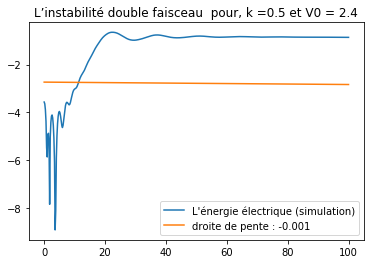

In [19]:
pl.title('L’instabilité double faisceau  pour, k ='+str(k)+' et V0 = '+str(v0))
pl.plot(time,np.log(l3_f),label="L'énergie électrique (simulation)")
pl.plot(time,np.log(0.065*np.exp(-0.001*time)),label='droite de pente : '+str(-0.001))
plt.legend()
plt.show()